# Statistical vs ML IDS — Friday DDoS
Compare a simple statistical detector (z-score) against an Isolation Forest on the Friday DDoS trace. We prevent leakage by fitting on benign windows only and evaluating on a held-out tail that still contains attacks.


In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix


from matplotlib import pyplot as plt
import time

plt.rcParams["figure.dpi"] = 120

## Load data


In [36]:
df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)
print("Raw rows, cols:", df.shape)

Raw rows, cols: (225745, 79)


## Timestamp, feature engineering, and selection


In [37]:
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.date_range(start="2017-07-07 15:00:00", periods=len(df), freq="10ms")
df = df.set_index('Timestamp')

df['packets'] = df['Total Fwd Packets'] + df['Total Backward Packets']
df['bytes']   = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']

keep = [
    'packets', 'bytes',
    'Destination Port',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'Min Packet Length', 'Max Packet Length',
    'SYN Flag Count', 'ACK Flag Count', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ECE Flag Count',
    'Subflow Fwd Packets', 'Subflow Bwd Packets',
    'Label'
]

df = df[keep]
df.head()

,packets,bytes,Destination Port,Packet Length Mean,Packet Length Std,Packet Length Variance,Min Packet Length,Max Packet Length,SYN Flag Count,ACK Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,ECE Flag Count,Subflow Fwd Packets,Subflow Bwd Packets,Label
Timestamp,,,,,,,,,,,,,,,,,
2017-07-07 15:00:00.000,2,12,54865,6.0,0.0,0.0,6,6,0,1,0,0,0,0,2,0,BENIGN
2017-07-07 15:00:00.010,2,12,55054,6.0,0.0,0.0,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.020,2,12,55055,6.0,0.0,0.0,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.030,2,12,46236,6.0,0.0,0.0,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.040,2,12,54863,6.0,0.0,0.0,6,6,0,1,0,0,0,0,2,0,BENIGN


## Aggregate into 5s windows and derive ground truth

Using 5s windows smooths packet bursts while staying near-real-time. A window is labelled attack if >50% of its flows are non-BENIGN.

In [38]:
agg = df.resample("5s").agg({
    'packets':'sum', 'bytes':'sum', 'Destination Port':'nunique',
    'Packet Length Mean':'mean', 'Packet Length Std':'mean', 'Packet Length Variance':'mean',
    'Min Packet Length':'mean', 'Max Packet Length':'mean',
    'SYN Flag Count':'sum', 'ACK Flag Count':'sum', 'FIN Flag Count':'sum', 'RST Flag Count':'sum', 'PSH Flag Count':'sum', 'ECE Flag Count':'sum',
    'Subflow Fwd Packets':'sum', 'Subflow Bwd Packets':'sum',
    
    # Fraction of flows that are labelled non-benign in the window
    'Label': lambda x: (x != 'BENIGN').mean()
})

agg['is_attack'] = (agg['Label'] > 0.5).astype(int)
agg = agg.drop(columns=['Label'])
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)
print(agg[['is_attack']].value_counts(normalize=True, dropna=False))

is_attack
1            0.564159
0            0.435841
Name: proportion, dtype: float64


## Train/test split without temporal leakage
Start the test set at the last 20% of attack windows so the evaluation contains positives. Models are fit only on benign windows from the training side.

Keep time order. Start the test set at the last 20% of attack-labelled windows so test contains positives. Fit both detectors only on benign training windows to avoid leakage.

In [39]:
attack_windows = agg.index[agg['is_attack'] == 1]
if len(attack_windows) == 0:
    raise ValueError("No attack-labelled windows found; cannot build split")

test_start = attack_windows[int(len(attack_windows) * 0.8)]
train = agg.loc[:test_start - pd.Timedelta(seconds=5)]
test = agg.loc[test_start:]

benign_train = train[train['is_attack'] == 0].copy()
print(
    f"Windows train={len(train)}, test={len(test)}, "
    f"train_attacks={train['is_attack'].sum()}, test_attacks={test['is_attack'].sum()}, "
    f"benign_for_fit={len(benign_train)}"
)

Windows train=320, test=132, train_attacks=204, test_attacks=51, benign_for_fit=116


## Statistical baseline: robust z-score

Features (packets/bytes/size + SYN/ACK) target DDoS surges. Mean/std come from benign-only windows; threshold is the 99th percentile of benign z-scores to favor precision. Lower the quantile for more recall.

In [50]:
Z_COLS = [
    'packets', 'bytes',
    'Packet Length Mean', 'Packet Length Std',
    'SYN Flag Count', 'ACK Flag Count'
]
train_mean = benign_train[Z_COLS].mean()
train_std = benign_train[Z_COLS].std(ddof=0).replace(0, 1)

agg['z_score'] = ((agg[Z_COLS] - train_mean) / train_std).abs().sum(axis=1)
# Threshold tuned on benign-only distribution
z_threshold = agg.loc[benign_train.index, 'z_score'].quantile(0.99)
agg['z_anomaly'] = (agg['z_score'] > z_threshold).astype(int)

## ML baseline: Isolation Forest (fit on benign windows)

Standardize features so no single dimension dominates. Train on benign windows only. 
contamination≈0.05 is a tuning knob (higher → more recall/FP). n_estimators=300 for stability.

In [51]:
features = [
    'packets', 'bytes', 'Packet Length Mean', 'Packet Length Std',
    'SYN Flag Count', 'ACK Flag Count', 'FIN Flag Count', 'RST Flag Count'
]

scaler = StandardScaler()
X_train = scaler.fit_transform(benign_train[features])

iso = IsolationForest(
    contamination=0.05,
    n_estimators=300,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)

agg['if_anomaly'] = iso.predict(scaler.transform(agg[features]))
agg['if_anomaly'] = (agg['if_anomaly'] == -1).astype(int)

## Evaluation on held-out test tail

Metrics are on the held-out tail only (chronologically after training).


In [52]:
def evaluate(name: str, column: str):
    y_true = test['is_attack']
    y_pred = agg.loc[test.index, column]
    print(f"=== {name} (test) ===")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

metrics = {
    'zscore': evaluate('Z-score', 'z_anomaly'),
    'isolation_forest': evaluate('Isolation Forest', 'if_anomaly')
}

=== Z-score (test) ===
              precision    recall  f1-score   support

           0      0.664     0.975     0.790        81
           1      0.846     0.216     0.344        51

    accuracy                          0.682       132
   macro avg      0.755     0.595     0.567       132
weighted avg      0.734     0.682     0.618       132

=== Isolation Forest (test) ===
              precision    recall  f1-score   support

           0      0.811     0.901     0.854        81
           1      0.810     0.667     0.731        51

    accuracy                          0.811       132
   macro avg      0.810     0.784     0.792       132
weighted avg      0.810     0.811     0.806       132



In [53]:
def show_cm(name: str, column: str):
    y_true = test['is_attack']
    y_pred = agg.loc[test.index, column]
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n=== {name} confusion matrix (test) ===")
    print(cm)
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

show_cm("Z-score", "z_anomaly")
show_cm("Isolation Forest", "if_anomaly")


=== Z-score confusion matrix (test) ===
[[79  2]
 [40 11]]
TN=79, FP=2, FN=40, TP=11

=== Isolation Forest confusion matrix (test) ===
[[73  8]
 [17 34]]
TN=73, FP=8, FN=17, TP=34


## Visualize detections

Yellow band marks the test window; red dots = z-score anomalies, blue x = Isolation Forest anomalies.


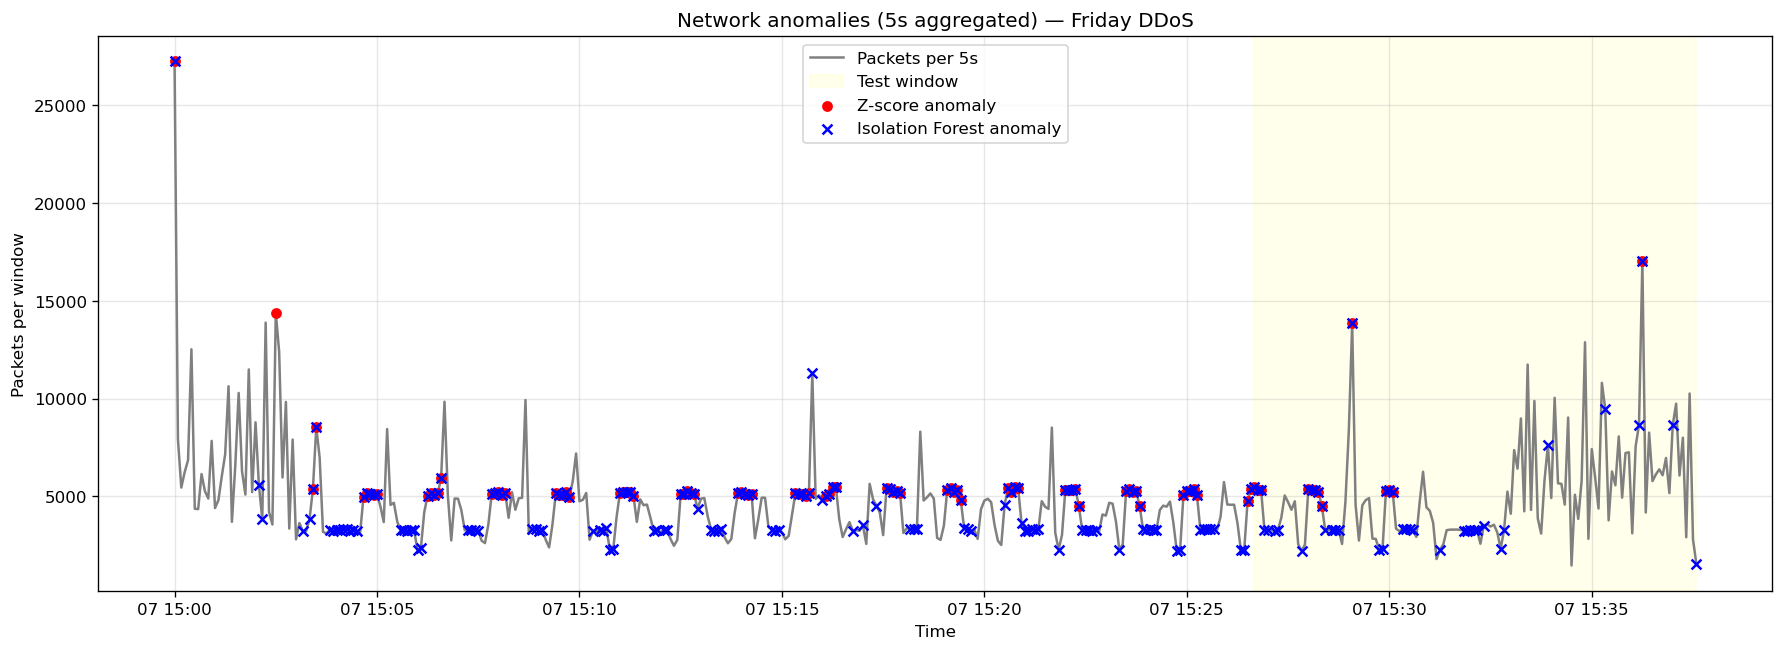

In [44]:
plt.figure(figsize=(18, 6))
plt.plot(agg.index, agg['packets'], color='grey', label='Packets per 5s')
plt.axvspan(test.index[0], test.index[-1], color='yellow', alpha=0.08, label='Test window')

plt.scatter(agg.index[agg['z_anomaly'] == 1], agg['packets'][agg['z_anomaly'] == 1],
            color='red', s=30, label='Z-score anomaly', zorder=3)
plt.scatter(agg.index[agg['if_anomaly'] == 1], agg['packets'][agg['if_anomaly'] == 1],
            color='blue', s=35, marker='x', label='Isolation Forest anomaly', zorder=4)

plt.title("Network anomalies (5s aggregated) — Friday DDoS")
plt.xlabel("Time")
plt.ylabel("Packets per window")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Streaming-style alerts


In [45]:
print("=== Real-time style alerts (prints only detected windows) ===")
for ts, row in agg.iterrows():
    if row['if_anomaly'] or row['z_anomaly']:
        print(
            f"[ALERT] {ts} | packets={row['packets']} | ports={row['Destination Port']} | "
            f"SYN={row['SYN Flag Count']} | attack={row['is_attack']} | IF={row['if_anomaly']} | Z={row['z_anomaly']}"
        )
        time.sleep(0.02)

=== Real-time style alerts (prints only detected windows) ===
[ALERT] 2017-07-07 15:00:00 | packets=27229.0 | ports=78.0 | SYN=29.0 | attack=0.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:02:05 | packets=5573.0 | ports=13.0 | SYN=4.0 | attack=0.0 | IF=1.0 | Z=0.0
[ALERT] 2017-07-07 15:02:10 | packets=3827.0 | ports=158.0 | SYN=32.0 | attack=0.0 | IF=1.0 | Z=0.0
[ALERT] 2017-07-07 15:02:30 | packets=14400.0 | ports=54.0 | SYN=20.0 | attack=0.0 | IF=0.0 | Z=1.0
[ALERT] 2017-07-07 15:03:10 | packets=3225.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=0.0
[ALERT] 2017-07-07 15:03:20 | packets=3836.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=0.0
[ALERT] 2017-07-07 15:03:25 | packets=5360.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:03:30 | packets=8554.0 | ports=16.0 | SYN=3.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:03:50 | packets=3287.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=0.0
[ALERT] 2017-07-07 15:03:55 | packets=3242.0 | ports=1